In [1]:
import re
import pandas as pd 
import numpy as np 
import seaborn as sns
import string
import nltk
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
train_df  = pd.read_csv('train_E6oV3lV.csv')
test_df = pd.read_csv('test_tweets_anuFYb8.csv')
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
data = train_df.append(test_df, ignore_index = True)

C:\Users\admn\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
# Removing twitter handle, special characters, numbers, punctuations, short words

data['tidy_tweet'] = data['tweet'].str.replace("@[\w]*", "")
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [10]:
# Tokenization is the process of splitting a string of text into tokens

tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [11]:
# Stemming is stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [12]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
data['tidy_tweet'] = tokenized_tweet
data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


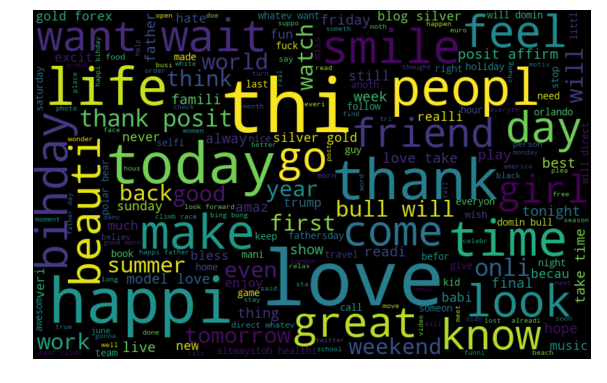

In [16]:
# Visualizing the most common words

from wordcloud import WordCloud

all_words = ' '.join([text for text in data['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

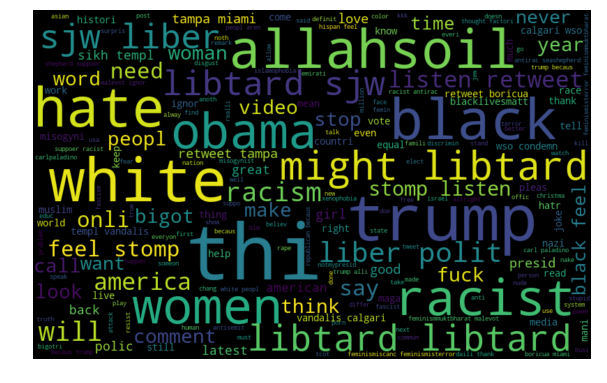

In [17]:
# Visualizing top racist/sexist words

all_words = ' '.join([text for text in data['tidy_tweet'][data['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [20]:
# Get hashtag lists

def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    return hashtags

In [33]:
hashtag_positive = hashtag_extract(data['tidy_tweet'][data['label'] == 0])
hashtag_negative = hashtag_extract(data['tidy_tweet'][data['label'] == 1])

# Unlisting
hashtag_positive = sum(hashtag_positive, [])
hashtag_negative = sum(hashtag_negative, [])

In [58]:
# converting hashtags from list to dataframe with count of each hashtag

from itertools import groupby

hashtag_positive.sort()
ht_positive = pd.DataFrame([(words, len(list(count))) for words, count in groupby(hashtag_positive)], columns = ['Hashtag', 'Count'])

hashtag_negative.sort()
ht_negative = pd.DataFrame([(words, len(list(count))) for words, count in groupby(hashtag_negative)], columns = ['Hashtag', 'Count'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Hashtag Negative')

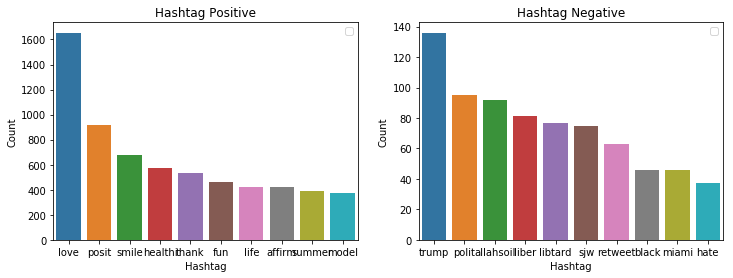

In [60]:
# visualizing top 10 most frequent hashtags

ht_positive = ht_positive.nlargest(columns = "Count", n = 10)
ht_negative = ht_negative.nlargest(columns = "Count", n = 10)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

ax = sns.barplot(x = 'Hashtag', y = 'Count', data = ht_positive, ax = axes[0])
ax.legend()
ax.set_title('Hashtag Positive')

ax = sns.barplot(x = 'Hashtag', y = 'Count', data = ht_negative, ax = axes[1])
ax.legend()
ax.set_title('Hashtag Negative')

In [64]:
# Bag-Of-Words approach

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(data['tidy_tweet'])

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 191504 stored elements in Compressed Sparse Row format>

In [62]:
# TF-IDF approach

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet'])

In [83]:
from sklearn.model_selection import train_test_split

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

X_train, X_test, y_train, y_test = train_test_split(train_bow, 
 train_df['label'], 
 test_size = 0.3, 
 random_state = 42)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 22373 samples.
Testing set has 9589 samples.


In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lreg = LogisticRegression()
lreg.fit(X_train, y_train)

prediction = lreg.predict_proba(X_test) 
pred_lreg = prediction[:,1] >= 0.3
pred_lreg = pred_lreg.astype(np.int)

print(classification_report(y_test, pred_lreg))
print(confusion_matrix(y_test, pred_lreg))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8905
           1       0.62      0.46      0.53       684

   micro avg       0.94      0.94      0.94      9589
   macro avg       0.79      0.72      0.75      9589
weighted avg       0.94      0.94      0.94      9589

[[8708  197]
 [ 366  318]]


In [85]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, 
 train_df['label'], 
 test_size = 0.3, 
 random_state = 42)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 22373 samples.
Testing set has 9589 samples.


In [86]:
lreg = LogisticRegression()
lreg.fit(X_train, y_train)

prediction = lreg.predict_proba(X_test) 
pred_lreg = prediction[:,1] >= 0.3
pred_lreg = pred_lreg.astype(np.int)

print(classification_report(y_test, pred_lreg))
print(confusion_matrix(y_test, pred_lreg))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8905
           1       0.69      0.45      0.54       684

   micro avg       0.95      0.95      0.95      9589
   macro avg       0.83      0.72      0.76      9589
weighted avg       0.94      0.95      0.94      9589

[[8768  137]
 [ 377  307]]
